<a href="https://colab.research.google.com/github/Kei-Sanada/Numerai/blob/master/Numerai_tournament_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numerapi
import numerapi

In [ ]:
import numpy as np
import pandas as pd
import os, sys
import gc
import pathlib
from typing import List, NoReturn, Union, Tuple, Optional, Text, Generic, Callable, Dict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, QuantileTransformer
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, mean_squared_error, mean_absolute_error, f1_score
from scipy.stats import spearmanr
import joblib

# model
import lightgbm as lgb
import xgboost as xgb
import operator

# visualize
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from matplotlib import pyplot
from matplotlib.ticker import ScalarFormatter
sns.set_context("talk")
style.use('seaborn-colorblind')

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
def get_int(x):
    try:
        return int(x[3:])
    except:
        return 1000
    
def read_data(data='train'):
    # get data 
    if data == 'train':
        df = pd.read_csv('https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_training_data.csv.xz')
    elif data == 'test':
        df = pd.read_csv('https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_tournament_data.csv.xz')
    
    # features
    feature_cols = df.columns[df.columns.str.startswith('feature')]
    
    # map to int, to reduce the memory demand
    mapping = {0.0 : 0, 0.25 : 1, 0.5 : 2, 0.75 : 3, 1.0 : 4}
    for c in feature_cols:
        df[c] = df[c].map(mapping).astype(np.uint8)
        
    # also cast era to int
    df["era"] = df["era"].apply(get_int)
    return df

In [ ]:
# %%Time

# load train　(半年間固定)
train = read_data('train')
print(train.shape)
train.head()

(501808, 314)


,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,feature_intelligence11,feature_intelligence12,feature_charisma1,feature_charisma2,feature_charisma3,feature_charisma4,feature_charisma5,feature_charisma6,feature_charisma7,feature_charisma8,feature_charisma9,feature_charisma10,feature_charisma11,feature_charisma12,feature_charisma13,feature_charisma14,feature_charisma15,feature_charisma16,feature_charisma17,feature_charisma18,feature_charisma19,feature_charisma20,feature_charisma21,feature_charisma22,feature_charisma23,feature_charisma24,feature_charisma25,...,feature_wisdom8,feature_wisdom9,feature_wisdom10,feature_wisdom11,feature_wisdom12,feature_wisdom13,feature_wisdom14,feature_wisdom15,feature_wisdom16,feature_wisdom17,feature_wisdom18,feature_wisdom19,feature_wisdom20,feature_wisdom21,feature_wisdom22,feature_wisdom23,feature_wisdom24,feature_wisdom25,feature_wisdom26,feature_wisdom27,feature_wisdom28,feature_wisdom29,feature_wisdom30,feature_wisdom31,feature_wisdom32,feature_wisdom33,feature_wisdom34,feature_wisdom35,feature_wisdom36,feature_wisdom37,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n000315175b67977,1,train,0,2,1,0,2,1,1,1,3,3,1,1,4,3,2,4,2,0,2,2,0,0,0,4,1,0,2,1,3,2,4,3,3,2,2,3,2,...,3,3,3,2,4,4,2,3,2,1,1,3,2,4,2,3,3,1,2,4,3,2,2,4,1,2,2,2,3,4,4,4,3,2,3,2,4,2,3,0.50
1,n0014af834a96cdd,1,train,0,0,0,1,2,0,0,1,2,2,0,2,0,2,2,2,2,2,1,1,2,0,4,2,2,2,3,2,2,3,1,2,3,2,1,3,2,...,1,1,1,4,4,2,2,2,0,1,4,2,4,4,2,2,2,4,1,3,4,1,1,4,2,2,2,3,3,3,4,4,0,0,3,1,0,1,4,0.25
2,n001c93979ac41d4,1,train,1,2,1,1,4,3,3,1,0,1,2,4,2,3,2,2,4,2,2,2,1,0,1,3,3,3,2,3,2,1,2,3,1,2,2,3,2,...,1,4,4,4,2,4,4,4,2,4,0,4,4,2,4,3,4,0,2,3,0,4,2,2,3,4,3,4,1,2,1,2,0,0,2,4,0,1,3,0.25
3,n0034e4143f22a13,1,train,4,0,0,2,2,1,1,3,1,2,2,2,3,2,4,2,2,0,4,0,3,0,2,2,2,2,0,2,2,3,3,2,1,2,2,2,2,...,4,4,3,3,4,3,3,3,4,3,4,3,4,3,4,0,2,3,4,3,4,3,4,4,0,2,3,3,4,3,4,4,3,3,4,4,3,4,4,0.25
4,n00679d1a636062f,1,train,1,1,1,1,0,1,2,1,1,2,1,1,3,2,0,2,2,1,0,2,0,2,1,2,2,2,2,2,2,2,3,2,1,2,2,2,2,...,4,1,3,4,3,0,0,3,2,4,2,3,1,2,0,2,2,2,3,3,2,3,1,3,2,2,1,1,3,2,3,3,1,2,3,0,2,1,3,0.75


In [ ]:
# %%time

# load test (毎週Roundごとに更新)
test = read_data('test')

In [ ]:
valid = test[test["data_type"] == "validation"].reset_index(drop = True)

# validation split
valid.loc[valid["era"] > 180, "valid2"] = True # むずいやつ
valid.loc[valid["era"] <= 180, "valid2"] = False # 簡単なやつ

In [ ]:
# remove data_type to save memory
train.drop(columns=["data_type"], inplace=True)
valid.drop(columns=["data_type"], inplace=True)
test.drop(columns=["data_type"], inplace=True)

print('The number of records: train {:,}, valid {:,}, test {:,}'.format(train.shape[0], valid.shape[0], test.shape[0]))

The number of records: train 501,808, valid 137,779, test 1,633,744


In [ ]:

# features (特徴量)
features = [f for f in train.columns.values.tolist() if 'feature' in f]
print('There are {} features.'.format(len(features)))
print(features)


There are 310 features.
['feature_intelligence1', 'feature_intelligence2', 'feature_intelligence3', 'feature_intelligence4', 'feature_intelligence5', 'feature_intelligence6', 'feature_intelligence7', 'feature_intelligence8', 'feature_intelligence9', 'feature_intelligence10', 'feature_intelligence11', 'feature_intelligence12', 'feature_charisma1', 'feature_charisma2', 'feature_charisma3', 'feature_charisma4', 'feature_charisma5', 'feature_charisma6', 'feature_charisma7', 'feature_charisma8', 'feature_charisma9', 'feature_charisma10', 'feature_charisma11', 'feature_charisma12', 'feature_charisma13', 'feature_charisma14', 'feature_charisma15', 'feature_charisma16', 'feature_charisma17', 'feature_charisma18', 'feature_charisma19', 'feature_charisma20', 'feature_charisma21', 'feature_charisma22', 'feature_charisma23', 'feature_charisma24', 'feature_charisma25', 'feature_charisma26', 'feature_charisma27', 'feature_charisma28', 'feature_charisma29', 'feature_charisma30', 'feature_charisma31',

In [ ]:
"""
# features (特徴量)
features = [f for f in train.columns.values.tolist() if 'feature' in f]
print('There are {} features.'.format(len(features)))
print(features)
"""

There are 310 features.
['feature_intelligence1', 'feature_intelligence2', 'feature_intelligence3', 'feature_intelligence4', 'feature_intelligence5', 'feature_intelligence6', 'feature_intelligence7', 'feature_intelligence8', 'feature_intelligence9', 'feature_intelligence10', 'feature_intelligence11', 'feature_intelligence12', 'feature_charisma1', 'feature_charisma2', 'feature_charisma3', 'feature_charisma4', 'feature_charisma5', 'feature_charisma6', 'feature_charisma7', 'feature_charisma8', 'feature_charisma9', 'feature_charisma10', 'feature_charisma11', 'feature_charisma12', 'feature_charisma13', 'feature_charisma14', 'feature_charisma15', 'feature_charisma16', 'feature_charisma17', 'feature_charisma18', 'feature_charisma19', 'feature_charisma20', 'feature_charisma21', 'feature_charisma22', 'feature_charisma23', 'feature_charisma24', 'feature_charisma25', 'feature_charisma26', 'feature_charisma27', 'feature_charisma28', 'feature_charisma29', 'feature_charisma30', 'feature_charisma31',

In [ ]:
train.head()

,id,era,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,feature_intelligence11,feature_intelligence12,feature_charisma1,feature_charisma2,feature_charisma3,feature_charisma4,feature_charisma5,feature_charisma6,feature_charisma7,feature_charisma8,feature_charisma9,feature_charisma10,feature_charisma11,feature_charisma12,feature_charisma13,feature_charisma14,feature_charisma15,feature_charisma16,feature_charisma17,feature_charisma18,feature_charisma19,feature_charisma20,feature_charisma21,feature_charisma22,feature_charisma23,feature_charisma24,feature_charisma25,feature_charisma26,...,feature_wisdom8,feature_wisdom9,feature_wisdom10,feature_wisdom11,feature_wisdom12,feature_wisdom13,feature_wisdom14,feature_wisdom15,feature_wisdom16,feature_wisdom17,feature_wisdom18,feature_wisdom19,feature_wisdom20,feature_wisdom21,feature_wisdom22,feature_wisdom23,feature_wisdom24,feature_wisdom25,feature_wisdom26,feature_wisdom27,feature_wisdom28,feature_wisdom29,feature_wisdom30,feature_wisdom31,feature_wisdom32,feature_wisdom33,feature_wisdom34,feature_wisdom35,feature_wisdom36,feature_wisdom37,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n000315175b67977,1,0,2,1,0,2,1,1,1,3,3,1,1,4,3,2,4,2,0,2,2,0,0,0,4,1,0,2,1,3,2,4,3,3,2,2,3,2,1,...,3,3,3,2,4,4,2,3,2,1,1,3,2,4,2,3,3,1,2,4,3,2,2,4,1,2,2,2,3,4,4,4,3,2,3,2,4,2,3,0.50
1,n0014af834a96cdd,1,0,0,0,1,2,0,0,1,2,2,0,2,0,2,2,2,2,2,1,1,2,0,4,2,2,2,3,2,2,3,1,2,3,2,1,3,2,2,...,1,1,1,4,4,2,2,2,0,1,4,2,4,4,2,2,2,4,1,3,4,1,1,4,2,2,2,3,3,3,4,4,0,0,3,1,0,1,4,0.25
2,n001c93979ac41d4,1,1,2,1,1,4,3,3,1,0,1,2,4,2,3,2,2,4,2,2,2,1,0,1,3,3,3,2,3,2,1,2,3,1,2,2,3,2,2,...,1,4,4,4,2,4,4,4,2,4,0,4,4,2,4,3,4,0,2,3,0,4,2,2,3,4,3,4,1,2,1,2,0,0,2,4,0,1,3,0.25
3,n0034e4143f22a13,1,4,0,0,2,2,1,1,3,1,2,2,2,3,2,4,2,2,0,4,0,3,0,2,2,2,2,0,2,2,3,3,2,1,2,2,2,2,2,...,4,4,3,3,4,3,3,3,4,3,4,3,4,3,4,0,2,3,4,3,4,3,4,4,0,2,3,3,4,3,4,4,3,3,4,4,3,4,4,0.25
4,n00679d1a636062f,1,1,1,1,1,0,1,2,1,1,2,1,1,3,2,0,2,2,1,0,2,0,2,1,2,2,2,2,2,2,2,3,2,1,2,2,2,2,1,...,4,1,3,4,3,0,0,3,2,4,2,3,1,2,0,2,2,2,3,3,2,3,1,3,2,2,1,1,3,2,3,3,1,2,3,0,2,1,3,0.75


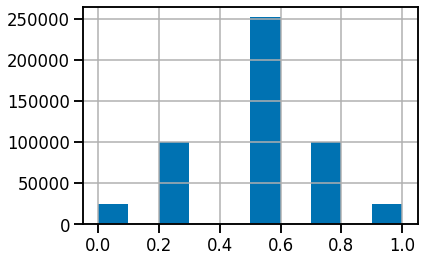

In [41]:

train["target"].hist()


In [ ]:
# # create a model and fit (公式example)
# model = xgb.XGBRegressor(max_depth=5, learning_rate=0.01, n_estimators=2000, n_jobs=-1, colsample_bytree=0.1)
# model.fit(train[features], train[target])

In [27]:
# %%time

# create a model and fit（LGBのハイパラは↑の公式XGBに寄せてみました）
params = {
            'n_estimators': 2000,
            'objective': 'regression',
            'boosting_type': 'gbdt',
            'max_depth': 5,
            'learning_rate': 0.01, 
            'feature_fraction': 0.1,
            'seed': 42
            }    
model = lgb.LGBMRegressor(**params)
model.fit(train[features], train['target'])

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.1, importance_type='split', learning_rate=0.01,
              max_depth=5, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=2000, n_jobs=-1, num_leaves=31,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, seed=42, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [30]:
pd.DataFrame(model.feature_importances_, index=features, columns=['importance']).sort_values(by='importance', ascending=False).style.background_gradient(cmap='viridis')

,importance
feature_dexterity11,418
feature_dexterity4,369
feature_dexterity6,362
feature_intelligence4,340
feature_intelligence1,338
feature_dexterity7,336
feature_dexterity12,332
feature_charisma63,324
feature_intelligence8,321
feature_strength10,302


Validation Score<BR>
Validationデータが与えられているので、訓練したモデルがどの程度のものか、スコアを計算してみましょう。金融モデルなので、ただ精度 (targetとのrank correlation)だけでなく、運用期間で安定したパフォーマンスを出せているかチェックします。多くの関数はNumeraiの公式Githubにあるので、拾って改変し使っていきます。

MMC（meta model correlation）は、運営のメタモデルが手に入らないため計算できませんが、精度 (rank correlation)と、精度と安定性のバランスを評価するcorrelation sharpeなどは、自分で計算できますので計算しましょう。以下の指標を、Validation期間を全て、前半（簡単なやつ）、後半（難しいやつ）に分けて計算しています。

rank correlation (NumeraiでCORRと呼ばれているもの。高いほど良い)
sharpe ratio（期間ベースでのCORR平均を標準偏差で割ったもの。高いほど良い）
max drawdown (ある1ラウンドでの最大の損失CORR。0に近いほど良い)
feature exposure (モデル予測値が一部の特徴量に依存している度合。低いほど良い)
実は提出すると、Numerai側で全部計算して自分のページで確認することができるのですが、全validation期間を使用したスコアのみが返ってくるため、「予測が難しい時期でもいいパフォーマンスが出ているか？」という肝心の疑問には答えてくれません。なので、自分で計算しましょう...^^

In [44]:
# naming conventions
PREDICTION_NAME = 'prediction'
TARGET_NAME = 'target'
# EXAMPLE_PRED = 'example_prediction'

# ---------------------------
# Functions
# ---------------------------
def valid4score(valid : pd.DataFrame, pred : np.ndarray, load_example: bool=True, save : bool=False) -> pd.DataFrame:
    """
    Generate new valid pandas dataframe for computing scores
    
    :INPUT:
    - valid : pd.DataFrame extracted from tournament data (data_type='validation')
    
    """
    valid_df = valid.copy()
    valid_df['prediction'] = pd.Series(pred).rank(pct=True, method="first")
#    valid_df.rename(columns={target: 'target'}, inplace=True)
    
    if load_example:
        valid_df[EXAMPLE_PRED] = pd.read_csv(EXP_DIR + 'valid_df.csv')['prediction'].values
    
    if save==True:
        valid_df.to_csv(OUTPUT_DIR + 'valid_df.csv', index=False)
        print('Validation dataframe saved!')
    
    return valid_df

def compute_corr(valid_df : pd.DataFrame):
    """
    Compute rank correlation
    
    :INPUT:
    - valid_df : pd.DataFrame where at least 2 columns ('prediction' & 'target') exist
    
    """
    
    return np.corrcoef(valid_df["target"], valid_df['prediction'])[0, 1]

def compute_max_drawdown(validation_correlations : pd.Series):
    """
    Compute max drawdown
    
    :INPUT:
    - validation_correaltions : pd.Series
    """
    
    rolling_max = (validation_correlations + 1).cumprod().rolling(window=100, min_periods=1).max()
    daily_value = (validation_correlations + 1).cumprod()
    max_drawdown = -(rolling_max - daily_value).max()
    
    return max_drawdown

def compute_val_corr(valid_df : pd.DataFrame):
    """
    Compute rank correlation for valid periods
    
    :INPUT:
    - valid_df : pd.DataFrame where at least 2 columns ('prediction' & 'target') exist
    """
    
    # all validation
    correlation = compute_corr(valid_df)
    print("rank corr = {:.4f}".format(correlation))
    return correlation
    
def compute_val_sharpe(valid_df : pd.DataFrame):
    """
    Compute sharpe ratio for valid periods
    
    :INPUT:
    - valid_df : pd.DataFrame where at least 2 columns ('prediction' & 'target') exist
    """
    # all validation
    d = valid_df.groupby('era')[['target', 'prediction']].corr().iloc[0::2,-1].reset_index()
    me = d['prediction'].mean()
    sd = d['prediction'].std()
    max_drawdown = compute_max_drawdown(d['prediction'])
    print('sharpe ratio = {:.4f}, corr mean = {:.4f}, corr std = {:.4f}, max drawdown = {:.4f}'.format(me / sd, me, sd, max_drawdown))
    
    return me / sd, me, sd, max_drawdown
    
def feature_exposures(valid_df : pd.DataFrame):
    """
    Compute feature exposure
    
    :INPUT:
    - valid_df : pd.DataFrame where at least 2 columns ('prediction' & 'target') exist
    """
    feature_names = [f for f in valid_df.columns
                     if f.startswith("feature")]
    exposures = []
    for f in feature_names:
        fe = spearmanr(valid_df['prediction'], valid_df[f])[0]
        exposures.append(fe)
    return np.array(exposures)

def max_feature_exposure(fe : np.ndarray):
    return np.max(np.abs(fe))

def feature_exposure(fe : np.ndarray):
    return np.sqrt(np.mean(np.square(fe)))

def compute_val_feature_exposure(valid_df : pd.DataFrame):
    """
    Compute feature exposure for valid periods
    
    :INPUT:
    - valid_df : pd.DataFrame where at least 2 columns ('prediction' & 'target') exist
    """
    # all validation
    fe = feature_exposures(valid_df)
    fe1, fe2 = feature_exposure(fe), max_feature_exposure(fe)
    print('feature exposure = {:.4f}, max feature exposure = {:.4f}'.format(fe1, fe2))
     
    return fe1, fe2

# to neutralize a column in a df by many other columns
def neutralize(df, columns, by, proportion=1.0):
    scores = df.loc[:, columns]
    exposures = df[by].values

    # constant column to make sure the series is completely neutral to exposures
    exposures = np.hstack(
        (exposures,
         np.asarray(np.mean(scores)) * np.ones(len(exposures)).reshape(-1, 1)))

    scores = scores - proportion * exposures.dot(
        np.linalg.pinv(exposures).dot(scores))
    return scores / scores.std()


# to neutralize any series by any other series
def neutralize_series(series, by, proportion=1.0):
    scores = series.values.reshape(-1, 1)
    exposures = by.values.reshape(-1, 1)

    # this line makes series neutral to a constant column so that it's centered and for sure gets corr 0 with exposures
    exposures = np.hstack(
        (exposures,
         np.array([np.mean(series)] * len(exposures)).reshape(-1, 1)))

    correction = proportion * (exposures.dot(
        np.linalg.lstsq(exposures, scores, rcond=None)[0]))
    corrected_scores = scores - correction
    neutralized = pd.Series(corrected_scores.ravel(), index=series.index)
    return neutralized


def unif(df):
    x = (df.rank(method="first") - 0.5) / len(df)
    return pd.Series(x, index=df.index)

def get_feature_neutral_mean(df):
    feature_cols = [c for c in df.columns if c.startswith("feature")]
    df.loc[:, "neutral_sub"] = neutralize(df, [PREDICTION_NAME],
                                          feature_cols)[PREDICTION_NAME]
    scores = df.groupby("era").apply(
        lambda x: np.corrcoef(x["neutral_sub"].rank(pct=True, method="first"), x[TARGET_NAME])).mean()
    return np.mean(scores)

def compute_val_mmc(valid_df : pd.DataFrame):    
    # MMC over validation
    mmc_scores = []
    corr_scores = []
    for _, x in valid_df.groupby("era"):
        series = neutralize_series(pd.Series(unif(x[PREDICTION_NAME])),
                                   pd.Series(unif(x[EXAMPLE_PRED])))
        mmc_scores.append(np.cov(series, x[TARGET_NAME])[0, 1] / (0.29 ** 2))
        corr_scores.append(np.corrcoef(unif(x[PREDICTION_NAME]).rank(pct=True, method="first"), x[TARGET_NAME]))

    val_mmc_mean = np.mean(mmc_scores)
    val_mmc_std = np.std(mmc_scores)
    val_mmc_sharpe = val_mmc_mean / val_mmc_std
    corr_plus_mmcs = [c + m for c, m in zip(corr_scores, mmc_scores)]
    corr_plus_mmc_sharpe = np.mean(corr_plus_mmcs) / np.std(corr_plus_mmcs)
    corr_plus_mmc_mean = np.mean(corr_plus_mmcs)

    print("MMC Mean = {:.6f}, MMC Std = {:.6f}, CORR+MMC Sharpe = {:.4f}".format(val_mmc_mean, val_mmc_std, corr_plus_mmc_sharpe))

    # Check correlation with example predictions
    corr_with_example_preds = np.corrcoef(valid_df[EXAMPLE_PRED].rank(pct=True, method="first"),
                                          valid_df[PREDICTION_NAME].rank(pct=True, method="first"))[0, 1]
    print("Corr with example preds: {:.4f}".format(corr_with_example_preds))
    
    return val_mmc_mean, val_mmc_std, corr_plus_mmc_sharpe, corr_with_example_preds
    
def score_summary(valid_df : pd.DataFrame):
    score_df = {}
    
    try:
        score_df['correlation'] = compute_val_corr(valid_df)
    except:
        print('ERR: computing correlation')
    try:
        score_df['corr_sharpe'], score_df['corr_mean'], score_df['corr_std'], score_df['max_drawdown'] = compute_val_sharpe(valid_df)
    except:
        print('ERR: computing sharpe')
    try:
        score_df['feature_exposure'], score_df['max_feature_exposure'] = compute_val_feature_exposure(valid_df)
    except:
        print('ERR: computing feature exposure')
    try:
        score_df['mmc_mean'], score_df['mmc_std'], score_df['corr_mmc_sharpe'], score_df['corr_with_example_xgb'] = compute_val_mmc(valid_df)
    except:
        print('ERR: computing MMC')
    
    return pd.DataFrame.from_dict(score_df, orient='index')

In [34]:
# prediction for valid periods   
pred = model.predict(valid[features])

In [45]:
# scores
valid_df = valid4score(valid, pred, load_example=False, save=False)

score_df = pd.DataFrame()
print('------------------')
print('ALL:')
print('------------------')
all_ = score_summary(valid_df).rename(columns={0: 'all'})

print('------------------')
print('VALID 1:')
print('------------------')
val1_ = score_summary(valid_df.query('era < 150')).rename(columns={0: 'val1'})

print('------------------')
print('VALID 2:')
print('------------------')
val2_ = score_summary(valid_df.query('era > 150')).rename(columns={0: 'val2'})

------------------
ALL:
------------------
rank corr = 0.0242
sharpe ratio = 0.8774, corr mean = 0.0247, corr std = 0.0282, max drawdown = -0.0801
feature exposure = 0.0894, max feature exposure = 0.2681
ERR: computing MMC
------------------
VALID 1:
------------------
rank corr = 0.0369
sharpe ratio = 1.3233, corr mean = 0.0369, corr std = 0.0279, max drawdown = -0.0285
feature exposure = 0.0824, max feature exposure = 0.2588
ERR: computing MMC
------------------
VALID 2:
------------------
rank corr = 0.0155
sharpe ratio = 0.6109, corr mean = 0.0156, corr std = 0.0255, max drawdown = -0.0521
feature exposure = 0.0993, max feature exposure = 0.2746
ERR: computing MMC


In [46]:
# scores
score_df = pd.concat([all_, val1_, val2_], axis=1)
score_df.style.background_gradient(cmap='viridis', axis=0)

,all,val1,val2
correlation,0.024194,0.036920,0.015464
corr_sharpe,0.877446,1.323335,0.610902
corr_mean,0.024729,0.036890,0.015608
corr_std,0.028183,0.027877,0.025550
max_drawdown,-0.080125,-0.028457,-0.052086
feature_exposure,0.089364,0.082426,0.099320
max_feature_exposure,0.268105,0.258812,0.274647


In [ ]:
"""
public_id = "NYANNYAN" # replace with yours
secret_key = "WANWAN" # replace with yours
model_id = "KOKEKOKKOOOO" # replace with yours
PREDICTION_NAME = "prediction_kazutsugi" # 現在はこれ（いずれprediction_nomiになるらしい）
OUTPUT_DIR = '' # prediction dataframeを保存するpath

def submit(tournament : pd.DataFrame, pred : np.ndarray, model_id='abcde'):
    predictions_df = tournament["id"].to_frame()
    predictions_df[PREDICTION_NAME] = pred
    
    # to rank
    predictions_df[PREDICTION_NAME] = predictions_df[PREDICTION_NAME].rank(pct=True, method="first")
    
    # save
    predictions_df.to_csv(pathlib.Path(OUTPUT_DIR + f"predictions_{model_id}.csv"), index=False)
    
    # Upload your predictions using API
    napi = numerapi.NumerAPI(public_id=public_id, secret_key=secret_key)
    submission_id = napi.upload_predictions(pathlib.Path(OUTPUT_DIR + f"predictions_{model_id}.csv"), model_id=model_id)
    print('submitted to {model_id}', model_id=model_id)
    
    return predictions_df
"""

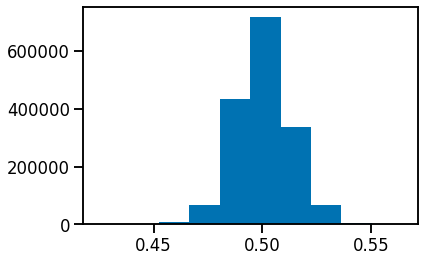

In [47]:
# prediction
pred = model.predict(test[features])
plt.hist(pred);

In [ ]:
# submit!（本当に提出する人はコメントアウトしてください）
# predictions_df = submit(tournament, pred, model_id=model_id)